# A Modular ETL Pipeline Using Python & PostgreSQL

## Load library and dependencies

In [1]:
# Import dependencies
import pandas as pd
from IPython.display import display
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent)) # Add parent directory
from dynamic_etl_pipeline import *

print("✅ Environment ready!")

✅ Environment ready!


## Extract (Load Raw Data)

In [7]:
# Trigger interactive source selection
result = select_and_load_source(ETL_CONFIG)

Dropdown(description='Data Source:', options=('all', 'zulo_bank', 'yanki_ecom', 'sales_retailx', 'csv_ex', 'ur…

Output()

In [12]:
print(f"ℹ️ Using global raw_df, cfg & dataset_key for selected_source : {dataset_key}")

ℹ️ Using global raw_df, cfg & dataset_key for selected_source : yanki_ecom


## Transform (Data Cleaning & Normalisation)

In [13]:
raw_df.nunique()

Order_ID               990
Customer_ID            990
Customer_Name          986
Product_ID            1000
Product_Name           628
Brand                  968
Category                 2
Price                  995
Quantity                10
Total_Price            999
Order_Date            1000
Shipping_Address      1000
City                   969
State                   50
Country                240
Postal_Code            994
Email                  999
Phone_Number          1000
Payment_Method           3
Transaction_Status       2
dtype: int64

### Cleaning Steps for Data Modeling & Normalization

| Step                         | Action                                                                                       | Purpose                                                       |
|------------------------------|----------------------------------------------------------------------------------------------|----------------------------------------------------------------|
| 1. Handle Missing Values     | - Drop rows with missing `Order_ID`, `Customer_ID`                      | These are core entity identifiers; nulls would break relationships |
|                              | - Optionally handle or impute 1 missing value in `State`                                    | Tolerable since it's likely a lookup/dimension table           |
| 2. Ensure Correct Data Types | - Convert `Order_Date` to datetime format                                                   | Enables partitioning and relationship with a Date dimension   |
|                              | - Ensure `Postal_Code` is treated as string if needed (for leading zeros)                   | Maintains data integrity, especially in US/UK postal codes     |
| 3. Remove Duplicates         | - Check for and drop duplicates in `Order_ID`, `Product_ID`, `Customer_ID` combinations     | Avoids redundant relationships or many-to-many mapping noise   |
| 4. Standardize Categorical Fields | - Lowercase and strip spaces in fields like `Category`, `Brand`, `Payment_Method`       | Ensures consistency across joins or dimensions                 |
| 5. Verify Key Relationships  | - Ensure 1:many mappings exist: `Customer` → `Order`, `Order` → `Product`                  | For proper normalization and referential integrity             |
| 6. Normalize Derived Fields  | - Confirm `Total_Price = Price * Quantity` or drop `Total_Price` if calculated later        | Avoid storing redundant calculations in normalized schema      |
| 7. Split Compound Columns    | - Split `Customer_Name` into `First_Name` and `Last_Name`                       | Improves normalization (optional but good practice)            |
| 8. Validate Contact Info     | - Basic regex or null check on `Email`, `Phone_Number`                                     | Prevent invalid records from entering DB                       |


### **Data Modelling (Raw → OLTP → OLAP)**

#### **Data Model**
*Splitting the data into normalized tables like:*  `Customers`, `Products`, `Orders`, `Location`, `Payments`

![zulobank](modeldesign/design_lucidchart_zulodb.png)

![yankiecom](modeldesign/design_drawio_yankidb.png)

### Clean & Normalise df to 3NF Tables

In [14]:
# Clean, split to normalised tables, check for missing pks and insert missing fk from config
oltp_tables, pk_dict, fk_dict, sk_dict = transform_oltp(dataset_key, cfg, raw_df)


  *************************

🔁 Processing yanki_ecom...

🧪 Processing source: yanki_ecom
[ensure_correct_dtypes] ✅ Converted 'Order_Date' to datetime (mixed format, normalized).
[handle_missing_critical] Dropped 20 rows with nulls in ['Order_ID', 'Customer_ID']
[split_compound_column] ✅ Split 'Customer_Name' into ['First_Name', 'Last_Name']
[split_compound_column] ✅ Split 'Shipping_Address' into ['Address', 'City', 'State', 'Postal_Code']
[validate_contact_info] Cleaned email in column 'Email'
[validate_contact_info] Cleaned phone in column 'Phone_Number'
[normalize_derived_fields] Created 'Total_Price' from Price * Quantity, rounded to 2dp.
[standardize_categoricals] Standardized fields: ['Order_ID', 'Customer_ID', 'Customer_Name', 'Product_ID', 'Product_Name', 'Brand', 'Category', 'Shipping_Address', 'City', 'State', 'Country', 'Postal_Code', 'Email', 'Phone_Number', 'Payment_Method', 'Transaction_Status', 'First_Name', 'Last_Name', 'Address']
✅ Finished processing: yanki_ecom — 100

### Inspect OLTP tables to be created in the DB

In [15]:
# Visualize and inspect all OLTP tables
display_database_info(oltp_tables, pk_dict, fk_dict, sk_dict)


=== Database Structure ===
Tables: ['location', 'payment', 'order', 'product', 'customer']



Primary Keys: {'customer': ['customer_id'], 'product': ['product_id'], 'location': ['location_id'], 'order': ['order_id'], 'payment': ['payment_id']}


Foreign Keys: {'order': [('customer_id', 'customer', 'customer_id'), ('product_id', 'product', 'product_id')], 'location': [('customer_id', 'customer', 'customer_id')], 'payment': [('order_id', 'order', 'order_id')]}


Surrogate Keys: {}

=== Table Details ===

📊 LOCATION
Rows: 990, Columns: 7

Sample Data:


,customer_id,address,city,state,postal_code,country,location_id
0,e0d6cb3c-c4b0-4cfe-8225-b65d094d2424,"psc 2224, box 2284",apo,ap,65880,kuwait,1
1,fa3ca35a-5540-404b-a7eb-9001cdcbd840,83909 johnson mall,"tranberg,",ms,99017,saint vincent and the grenadines,2
2,7ad4de53-e6d7-4cd3-99b8-13fb70fe7a34,82101 johnson flat west,"ryan,",ms,29075,france,3



Column Info:


customer_id    object
address        object
city           object
state          object
postal_code    object
country        object
location_id     Int64
dtype: object

--------------------------------------------------

📊 PAYMENT
Rows: 990, Columns: 4

Sample Data:


,order_id,payment_method,transaction_status,payment_id
0,e32af09a-b6ab-497e-af3a-331e4d4ed6e7,debit card,completed,e32af09a-b6ab-497e-af3a-331e4d4ed6e7
1,86eb8859-14ab-4d4e-9267-c5826f4e0c8e,credit card,completed,86eb8859-14ab-4d4e-9267-c5826f4e0c8e
2,7379b560-8897-4623-92a2-523ddcdc43a1,paypal,pending,7379b560-8897-4623-92a2-523ddcdc43a1



Column Info:


order_id              object
payment_method        object
transaction_status    object
payment_id            object
dtype: object

--------------------------------------------------

📊 ORDER
Rows: 990, Columns: 6

Sample Data:


,order_id,customer_id,product_id,quantity,total_price,order_date
0,e32af09a-b6ab-497e-af3a-331e4d4ed6e7,e0d6cb3c-c4b0-4cfe-8225-b65d094d2424,2ef6e8fa-6a36-4515-b1c2-a0a700abf386,2,501.14,2020-06-03
1,86eb8859-14ab-4d4e-9267-c5826f4e0c8e,fa3ca35a-5540-404b-a7eb-9001cdcbd840,3ba38e01-f8e7-4af2-9246-87ef0961d4f5,6,1078.86,2020-07-31
2,7379b560-8897-4623-92a2-523ddcdc43a1,7ad4de53-e6d7-4cd3-99b8-13fb70fe7a34,a58c53bd-a34b-4541-b926-bec9eb84cac2,7,4203.85,2021-11-05



Column Info:


order_id               object
customer_id            object
product_id             object
quantity                int64
total_price           float64
order_date     datetime64[ns]
dtype: object

--------------------------------------------------

📊 PRODUCT
Rows: 990, Columns: 5

Sample Data:


,product_id,product_name,brand,category,price
0,2ef6e8fa-6a36-4515-b1c2-a0a700abf386,despite,"lawson, stone and campos",perfume oil,250.57
1,3ba38e01-f8e7-4af2-9246-87ef0961d4f5,sea,washington group,perfume oil,179.81
2,a58c53bd-a34b-4541-b926-bec9eb84cac2,suddenly,rodgers ltd,perfume oil,600.55



Column Info:


product_id       object
product_name     object
brand            object
category         object
price           float64
dtype: object

--------------------------------------------------

📊 CUSTOMER
Rows: 990, Columns: 5

Sample Data:


,customer_id,first_name,last_name,email,phone_number
0,e0d6cb3c-c4b0-4cfe-8225-b65d094d2424,dominic,buchanan,margaret97@example.com,2596036134
1,fa3ca35a-5540-404b-a7eb-9001cdcbd840,daniel,allen,angela55@example.com,+18696594272982
2,7ad4de53-e6d7-4cd3-99b8-13fb70fe7a34,daniel,schmidt,wayne59@example.org,2928400975724



Column Info:


customer_id     object
first_name      object
last_name       object
email           object
phone_number    object
dtype: object

--------------------------------------------------


### Save normalised tables to csv (optional)

In [16]:
#save_tables_to_csv(tables=oltp_tables, export_dir="dataset/")

## Load to postgreSQL

### DB CONNECTION

In [17]:
conn = get_db_connection(env_prefix="YANKI_DB_") # YANKI_DB_ , ZULO_DB_

[get_db_connection] ✅ Connected to 'user=postgres password=xxx dbname=yanki_ecomm host=localhost port=5432' using prefix 'YANKI_DB_'


### Run ETL Pipeline (OLTP /OLAP)

In [18]:
result = run_dynamic_etl_pipeline(conn, dataset_key, raw_df, cfg, oltp_tables,pk_dict,fk_dict,sk_dict)
print(result)


 oltp_tables exist, proceeding with schema creation

  *************************
🧱 Creating OLTP schema and tables...
📦 Creating OLTP schema: yanki_oltp
⏩ yanki_oltp.location exists — skipping
⏩ yanki_oltp.payment exists — skipping
⏩ yanki_oltp.order exists — skipping
⏩ yanki_oltp.product exists — skipping
⏩ yanki_oltp.customer exists — skipping
⏩ FK exists: fk_order_customer_id_to_customer_customer_id — skipping
⏩ FK exists: fk_order_product_id_to_product_product_id — skipping
⏩ FK exists: fk_location_customer_id_to_customer_customer_id — skipping
⏩ FK exists: fk_payment_order_id_to_order_order_id — skipping
✅ OLTP schema and constraints applied.


  *************************
📥 Loading OLTP data into DB...
🔁 Insert Order: ['location', 'payment', 'order', 'product', 'customer']
[UPSERT] ✅ Inserted 990 rows into yanki_oltp.customer
   ✅ customer (990 rows)
[UPSERT] ✅ Inserted 990 rows into yanki_oltp.product
   ✅ product (990 rows)
[UPSERT] ✅ Inserted 990 rows into yanki_oltp.order
   

In [20]:
if result["success"]:
    if "olap" not in cfg:
        print("✅ OLTP pipeline completed. No OLAP schema configured.")
    else:
        display_olap_info(conn, cfg)
else:
    print("❌ Pipeline failed. Please fix the errors before proceeding.")

✅ OLTP pipeline completed. No OLAP schema configured.


## Export insert sql script to file

In [ ]:
# Generate SQL script to insert to the database table (Optional)
export_sql_script(
    schema= "yanki_oltp",
    tables= oltp_tables,
    foreign_keys= fk_dict,
    output_sql_path= "sqlscript/yanki_insert.sql"
)

## Visualise ERD

✅ OLTP-only model. Displaying OLTP ERD...


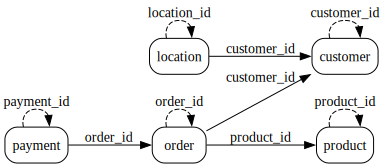

In [27]:
if "olap" not in cfg:
    print("✅ OLTP-only model. Displaying OLTP ERD...")
    complete_erd = generate_erd_graph(fk_dict, sk_dict=pk_dict, title=f"{dataset_key} - OLTP Model")
    display(complete_erd)
else:
    print("📊 Displaying complete OLTP/OLAP model...")
    complete_erd = generate_erd_graph(
        fk_dict={**cfg["oltp"]["foreign_keys"], **cfg["olap"]["olap_foreign_keys"]},
        schema_type="both",
        sk_dict=sk_dict,
        title="Complete Data Model"
    )
    display(complete_erd)

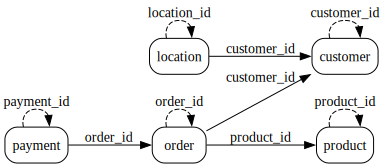

In [21]:
oltp_erd = generate_erd_graph(fk_dict, sk_dict=pk_dict, title=f"{dataset_key} - OLTP ERD")
display(oltp_erd)

In [23]:
# For OLAP ERD 
if "olap" not in cfg:
    print("✅ OLTP pipeline completed. No OLAP schema configured.")
else:
    olap_erd = generate_erd_graph(cfg["olap_foreign_keys"], title=f"{dataset_key} - OLAP ERD")
    display(olap_erd)

✅ OLTP pipeline completed. No OLAP schema configured.
